## 1. Generate tiles image

In [3]:
from PIL import Image
import os

def get_all_char_before_dot(s):
    dot_index = s.find('.')
    if dot_index > 0:
        return s[:dot_index]
    else:
        return None  # Return None if there's no character before the dot

def generate_tiles(image_path, tile_width, tile_height, step, output_folder):
    # Open the image
    image = Image.open(image_path)
    image_width, image_height = image.size

    # Generate tiles
    for x in range(0, image_width - tile_width + 1, step):
        for y in range(0, image_height - tile_height + 1, step):
            # Define the bounding box for the current tile
            left = x
            upper = y
            right = left + tile_width
            lower = upper + tile_height
            bbox = (left, upper, right, lower)

            # Crop the image to the bounding box to create the tile
            tile = image.crop(bbox)

            # Save the tile to the output folder
            image_file_name=os.path.basename(image_path)
            image_idx = get_all_char_before_dot(image_file_name)
            tile.save(f"{output_folder}/{image_idx}_{x}_{y}.png") #image_id_x_y.png

    print(f"Tiles from {image_file_name} are generated successfully.")


In [4]:
# Generate tiles for original images
os.makedirs('Patch', exist_ok=True)

for i in range(1,13): #12 images
    generate_tiles(f"D:\Projects\AICity\Tiles\Tiles\\{i}.jpg", 100, 100, 50, "Patch")

Tiles from 1.jpg are generated successfully.
Tiles from 2.jpg are generated successfully.
Tiles from 3.jpg are generated successfully.
Tiles from 4.jpg are generated successfully.
Tiles from 5.jpg are generated successfully.
Tiles from 6.jpg are generated successfully.
Tiles from 7.jpg are generated successfully.
Tiles from 8.jpg are generated successfully.
Tiles from 9.jpg are generated successfully.
Tiles from 10.jpg are generated successfully.
Tiles from 11.jpg are generated successfully.
Tiles from 12.jpg are generated successfully.


## 2. Create dataset using tiles

Labels are in the folder names

In [1]:
import os
import cv2
import numpy as np
import json

# Function to load annotations from a JSON file
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        return json.load(f)

In [2]:
annotation_files = ['D:\Projects\AICity\Tiles\Tiles\instances_1_2_3.json',
                    'D:\Projects\AICity\Tiles\Tiles\instances_4_5_6.json',
                    'D:\Projects\AICity\Tiles\Tiles\instances_7_8_9.json',
                    'D:\Projects\AICity\Tiles\Tiles\instances_10_11_12.json']
# Ensure the output directory exists
os.makedirs('Annotations', exist_ok=True)

In [23]:
#label encouding (amnual)
building_code = [0,1]

colour_code = {'White':1,
                'Red':2,
                'Black':3,
                'Green':4,
                'Blue':5,
                'Brown':6,
                'Grey':7,
                'Orange':8,
                'Yellow':9}

texture_code = {'Rough':1,
                 'Average':2,
                 'Smooth':3}

score_code = {'100':10,
               '90':9,
               '80':8,
               '70':7,
               '60':6,
               '50':5
               }

material_code = {'Concrete':1,
                  'Concrete Slate':2,
                  'Concrete Tiles':3,
                  'Concrete Ballast':4,
                  'Metal':5,
                  'Metal Tile':6,
                  'Steel':7,
                  'Green':8,
                  'Tiles':9,
                  'Glass':10,
                  'Asphalt Shingles':11,
                  'Bitumen':12,
                  'EPDM':13,
                  'Slate':14,
                  'Stone Tile':15,
                  'Complex':16,
                  'Solar':17
               }
               

In [30]:
images = []
building_masks =[]
colour_masks=[]
texture_masks=[]
score_masks=[]
materials_masks=[]
image_dir = 'Tiles\Tiles'

for i,file in enumerate (annotation_files):
    annotation_data=load_annotations(file)
    for image_info in annotation_data['images']:
        image_path = os.path.join(image_dir, image_info['file_name'])
        # Load the original image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if image is None:
            print(f"Failed to load original image at {image_path}")
        else:
            print(f"Successfully load original image at {image_path}")
            images.append(image)
            building_masks.append(np.zeros(image.shape[:2],int))#we only need one channel for masks
            colour_masks.append(np.zeros(image.shape[:2],int))#we only need one channel for masks
            texture_masks.append(np.zeros(image.shape[:2],int))#we only need one channel for masks
            score_masks.append(np.zeros(image.shape[:2],int))#we only need one channel for masks
            materials_masks.append(np.zeros(image.shape[:2],int))#we only need one channel for masks


    for annotation in annotation_data['annotations']:
        #get annotation values from the datafile
        id = annotation['id']
        image_idx = annotation['image_id']
        region = annotation['segmentation']
        area = annotation['area']
        bbox = annotation['bbox']
        a_colour = annotation['attributes']['Colours']
        a_texture = annotation['attributes']['Textures']
        a_score = annotation['attributes']['Score']
        a_materials = annotation['attributes']['Materials']
        a_occluded = annotation['attributes']['occluded']
            
        #Building masks
        polygon = np.reshape(region,(int(np.size(region)/2),2)).astype(np.int32).reshape((-1, 1, 2))#format change to opencv polygon x and y pairs
        building_masks[i*3+image_idx-1]  = cv2.fillPoly(building_masks[i*3+image_idx-1] ,[polygon],color=building_code[1])

        #Colour masks
        colour_masks[i*3+image_idx-1] = cv2.fillPoly(colour_masks[i*3+image_idx-1],[polygon],color=colour_code[a_colour])
        
        # #Texture masks
        texture_masks[i*3+image_idx-1] = cv2.fillPoly(texture_masks[i*3+image_idx-1],[polygon],color=texture_code[a_texture])

        # Score masks
        score_masks[i*3+image_idx-1] = cv2.fillPoly(score_masks[i*3+image_idx-1],[polygon],color=score_code[a_score])

        # Material masks
        materials_masks[i*3+image_idx-1] = cv2.fillPoly(materials_masks[i*3+image_idx-1],[polygon],color=material_code[a_materials])
        

Successfully load original image at Tiles\Tiles\1.jpg
Successfully load original image at Tiles\Tiles\2.jpg
Successfully load original image at Tiles\Tiles\3.jpg
Successfully load original image at Tiles\Tiles\4.jpg
Successfully load original image at Tiles\Tiles\5.jpg
Successfully load original image at Tiles\Tiles\6.jpg
Successfully load original image at Tiles\Tiles\7.jpg
Successfully load original image at Tiles\Tiles\8.jpg
Successfully load original image at Tiles\Tiles\9.jpg
Successfully load original image at Tiles\Tiles\10.jpg
Successfully load original image at Tiles\Tiles\11.jpg
Successfully load original image at Tiles\Tiles\12.jpg


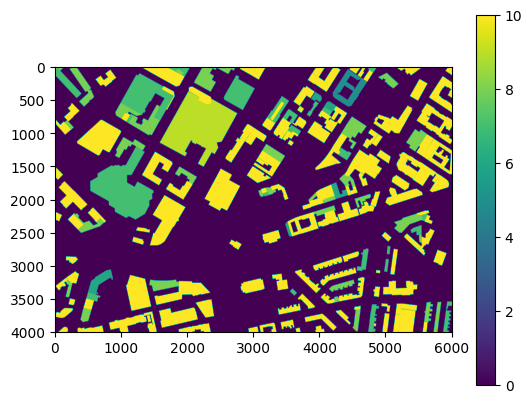

In [32]:
import matplotlib.pyplot as plt
pos  = plt.imshow(score_masks[1])
plt.colorbar(pos)

In [70]:
from PIL import Image
im = Image.fromarray
def generate_tiles_from_masks(image_idx, image_mask, tile_width, tile_height, step, output_folder):
    # Open the image
    image_mask = Image.fromarray(image_mask[:,:,0]*255)
    image_width, image_height= image_mask.size

    # Generate tiles
    for x in range(0, image_width - tile_width + 1, step):
        for y in range(0, image_height - tile_height + 1, step):
            # Define the bounding box for the current tile
            left = x
            upper = y
            right = left + tile_width
            lower = upper + tile_height
            bbox = (left, upper, right, lower)

            # Crop the image to the bounding box to create the tile
            tile = image_mask.crop(bbox)

            # Save the tile to the output folder
            tile.save(f"{output_folder}/{image_idx}_{x}_{y}.png") #image_id_x_y.png

    print(f"Tiles from image id {image_idx} are generated successfully.")

In [71]:
for idx, mask in enumerate(building_masks): #12 images
    generate_tiles_from_masks(idx+1, mask, 100, 100, 50, "Annotations")


Tiles from image id 1 are generated successfully.
Tiles from image id 2 are generated successfully.
Tiles from image id 3 are generated successfully.
Tiles from image id 4 are generated successfully.
Tiles from image id 5 are generated successfully.
Tiles from image id 6 are generated successfully.
Tiles from image id 7 are generated successfully.
Tiles from image id 8 are generated successfully.
Tiles from image id 9 are generated successfully.
Tiles from image id 10 are generated successfully.
Tiles from image id 11 are generated successfully.
Tiles from image id 12 are generated successfully.
